In [1]:
import numpy as np
import copy
import pandas as pd
from skimage.feature import peak_local_max
import os
import copy

%matplotlib inline
import matplotlib.pyplot as plt

#CODATA 2017
kB = 1.38064903E-23  #J/K
Na = 6.022140758E+23 #1/mol

In [2]:
import feasst

In [3]:
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import FormatStrFormatter

In [4]:
source = "/home/local/NIST/dsideriu/Workstation_Research/Monte_Carlo/my_FEASST/MFI_Argon/MFI_DIMERArgon_LJLFS/tmp/"

In [10]:
# Space
space_file = source+"rst_core0space"
space = feasst.Space(space_file)

print([space.boxLength(x) for x in range(3)])


[40.18, 39.476, 39.426]


In [12]:
# Criteria (e.g., data from colMat files)

criteria = feasst.CriteriaWLTMMC(source+"rst_core0criteria")

beta = criteria.beta()
lnZ = np.log(criteria.activ(0))

print(beta,lnZ)

nMin = int(np.ceil(criteria.mMin()))
nMax = int(np.floor(criteria.mMax()))
N = np.array([x for x in range(nMin,nMax+1)])

lnPi = np.array(criteria.lnPIdouble())
print(lnPi[0:10])
bins = len(lnPi)

energy = np.array([ criteria.pe(i).sumDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)])
#energy2 = np.array([ criteria.pe(i).sumSqDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)])
print(energy[0:10])


0.4009078729 -2.999999999957096
[-282.42137932 -270.75148595 -259.72555189 -249.11416869 -238.96512636
 -228.92117023 -218.96490755 -209.67192267 -200.2895179  -190.95316909]
[3994568.93574479 3994546.3155243  3994523.69996497 3994501.05917022
 3994478.32989742 3994455.66995051 3994433.01520937 3994410.12009268
 3994387.3426684  3994364.56508297]


In [3]:
def read_feasst_restarts(stub):
    space = feasst.Space(stub+"space")
    boxLength = [space.boxLength(0),space.boxLength(1),space.boxLength(2)]

    criteria = feasst.CriteriaWLTMMC(stub+"criteria")
    beta = criteria.beta()
    lnZ = np.log(criteria.activ(0))

    nMin = int(np.ceil(criteria.mMin()))
    nMax = int(np.floor(criteria.mMax()))
    N = np.array([x for x in range(nMin,nMax+1)])

    lnPi = np.array(criteria.lnPIdouble())
    bins = len(lnPi)
    energy = np.array([ criteria.pe(i).sumDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)])
    energy2 = np.array([ criteria.pe(i).sumSqDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)])
    #energy = np.array([ criteria.pe(i).sumDble()/criteria.pe(i).nValues() for i in range(0,bins)])
    #energy2 = np.array([ criteria.pe(i).sumSqDble()/criteria.pe(i).nValues() for i in range(0,bins)])
    
    return N, lnPi, energy, energy2, beta, lnZ

def splice_window_data(source,prefix):
    input_files = [ x for x in os.listdir(source) if (prefix in x and "space" in x and "bak" not in x and "rng" not in x) ]
    windows = len(input_files)

    for i in range(windows):
        stub = source+ "/" + prefix+str(i)
        N_w, lnPi_w, energy_w, energy2_w, beta_w, lnZ0_w = read_feasst_restarts(stub)
        if i == 0:
            beta = beta_w
            lnZ = lnZ0_w
            Nmin = N_w[0]
            Nmax = N_w[-1]
            lnPi_master = np.array(lnPi_w)
            energy_master = np.array(energy_w)
            energy2_master = np.array(energy2_w)
        else: #assumes overlap = 1 [need to generalize]
            reference = N_w[0]
            lnPi_w = lnPi_w+(lnPi_master[reference]-lnPi_w[0])
            lnPi_master = np.concatenate([lnPi_master,lnPi_w[1:]])
            #Simple splicing of the energy terms
            energy_master = np.concatenate([energy_master,energy_w[1:]])
            energy2_master = np.concatenate([energy2_master,energy2_w[1:]])
            Nmax = max(Nmax,N_w[-1])
        #print('Reading data:', i, Nmin, Nmax)
    N_master = np.array(range(Nmin,Nmax+1))

    # Normalize lnPi
    lnPi_master = lnPi_master - max(lnPi_master)
    lnPi_master = lnPi_master - np.log(sum(np.exp(lnPi_master)))
    # Adjust Energy so that E(Nmin) = 0
    energy2_master = energy2_master - 2.*energy_master[0]*energy_master + energy_master[0]**2
    energy_master = energy_master - energy_master[0]

    return N_master, lnPi_master, energy_master, energy2_master, beta, lnZ

In [4]:
#Necessary Packages
#import numpy as np
#import copy
#from scipy.signal import argrelextrema
#from skimage.feature import peak_local_max

class FHMC_Analysis:
    def __init__(self,lnZ0,V,beta,Debug=False,Extrapolated=False,extrema_search=[5, 10, 15, 20, 25],max_phases=2):
        self.N = np.array([])
        self.lnPi = np.array([])
        self.energy = np.array([])
        self.energy2 = np.array([])   #Square of the energy; think about better data structure
        self.lnZ0 = lnZ0
        self.V = V
        self.beta = beta
        self.Debug = Debug
        self.Extrapolated = Extrapolated
        self.extrema_search = extrema_search
        self.max_phases = max_phases
    def locate_maxima( self ):
        for search in self.extrema_search:
            test = peak_local_max( self.lnPi, min_distance=search )
            if len(test) <= self.max_phases:
                maxima = test
                break #Find a better way to loop than breaking
            if search == self.extrema_search[-1]:
                raise ValueError('%i maxima found greater than %i at mu %s' %
                        ( len(test), self.max_phases, repr(self.lnZ0) ) )
        if len(maxima) == 0:
            #an endpoint is the global maximum
            if self.lnPi[0] > self.lnPi[-1]:
                return [0]
            else:
                return [self.N[-1]]
        else:
            return maxima[0]
        
    def CheckTail_func(self,threshold):
        #maxima = argrelextrema( self.lnPi, np.greater )
        #maxima = peak_local_max( self.lnPi )
        maxima = self.locate_maxima()
        delta = np.abs(self.lnPi[int(maxima[-1])] - self.lnPi[-1])
        if delta < threshold:
            return False
        else:
            return True    
    def reweight(self,lnZ_rw, Normalize=False, Output=False, CheckTail=False):
        # Reweighting operation
        lnPi_temp = self.lnPi + self.N*(lnZ_rw-self.lnZ0)
        # Shift relative to max value
        lnPi_temp = lnPi_temp - max(lnPi_temp)
        # Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi and lnZ
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.lnZ0 = lnZ_rw
        child.lnPi = np.array(lnPi_temp)
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nReweighted to lnZ = '+str(lnZ_rw)+'\n' \
                                'Insufficient Tail \n')

        return child
    def temperature_extrapolate(self,beta_extrap, order=1, Normalize=False, CheckTail=False):
        if self.Extrapolated:
            raise Exception('\nNO NO NO\nDo not extrapolate already-extrapolated lnPi!')
        mu = self.lnZ0/self.beta
        if order < 1:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #First Order Extrapolation
        lnPi_temp = self.lnPi + (beta_extrap - self.beta)*(mu*self.N - self.energy)
        #NOTE: Inconsequential terms were skipped; they are all independent of N
        #      and so do not affect the relative values of Pi
        if order == 2:
            #Second Order Extrapolation            
            lnPi_temp = lnPi_temp + 0.50 * ((beta_extrap - self.beta)**2)*(self.energy2 - (self.energy)**2)
            #NOTE: As for first order extrap, inconsequential terms were skipped
        if order > 2:
            raise Exception('\nExtrapolation Order = '+str(order)+' not possible\n' \
                                'Check your input data')
        #Normalize, if desired
        if Normalize: lnPi_temp = lnPi_temp - np.log( np.sum( np.exp(lnPi_temp) ) )
        # Create a child object and replace the lnPi, lnZ and beta
        child = copy.deepcopy(self) # double ensure that the child is a new object, not a pointer
        child.beta = beta_extrap
        child.lnZ0 = self.lnZ0*beta_extrap/self.beta
        child.lnPi = lnPi_temp
        child.Extrapolated = True
        # Check the tail of the distribution
        if CheckTail:
            if not child.CheckTail_func(threshold=10.0):
                raise Exception('\nExtrapolated to beta = '+str(beta_extrap)+'\n' \
                                'Insufficient Tail')
        return child
    def phase_boundaries(self):
        maxima = self.locate_maxima()
        if len(maxima) == 1:
            Nbound = self.N[-1]
            phases = 1
        elif ln(maxima) == 2:
            #minima = argrelextrema( self.lnPi, np.less, order=10 )
            minima = peak_local_max( -self.lnPi )[0]
            Nbound = int(minima[0])
            phases = 2
        else:
            raise ValueError('%i maxima found greater than %i at mu %s' %
                        ( len(maxima), self.max_phases, repr(self.lnZ0) ) )
            #raise Exception('\nMore than two maxima in lnPi\n'+\
            #                'Current lnZ = '+str(self.lnZ))                       
        return phases, Nbound

    #Function for computing ensemble properties
    def ensemble_properties(self):
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Navg = np.dot( self.N, Pi )/denom
        N2avg = np.dot( (self.N)**2, Pi )/denom
        Uavg = np.dot( self.energy, Pi )/denom
        U2avg = np.dot( self.energy2, Pi )/denom
        UNavg = np.dot( np.multiply(self.N,self.energy), Pi )/denom
        #Determine a better way to output all of these moments
        return {"N": [Navg,N2avg],
                "U": [Uavg,U2avg],
                "UN": UNavg}

    #Function for computing phase properties
    def phase_properties(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Navg = [ [0. for x in range(phases)] for i in range(2) ]
        Uavg = [0. for x in range(phases)]
        UNavg = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                for j in range(2):
                    Navg[j][i] = np.dot( self.N[:Nbound]**(j+1), Pi[:Nbound] )/denom
                Uavg[i] = np.dot( self.energy[:Nbound], Pi[:Nbound] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[:Nbound],self.energy[:Nbound]),Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                for j in range(2):
                    Navg[i] = np.dot( self.N[Nbound+1:]**(j+1), Pi[Nbound+1:] )/denom
                Uavg[i] = np.dot( self.energy[Nbound+1:], Pi[Nbound+1:] )/denom
                UNavg[i] = np.dot( np.multiply(self.N[Nbound+1:],self.energy[Nbound+1:]),Pi[Nbound+1:] )/denom            
        return {"N": Navg,
                "U": Uavg,
                "UN": UNavg}
    
    def grand_potential(self):
        # Phase-specific properties
        phases, Nbound = self.phase_boundaries()
        # Create list
        Omega = [0. for x in range(phases)]
        for i in range(phases):
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                lnPi_shifted = self.lnPi - max( self.lnPi[:Nbound] )
                Pi = np.exp( lnPi_shifted )
                Omega[i]=(lnPi_shifted[0] - np.log(np.sum(Pi[:Nbound])))/self.beta
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                lnPi_shifted = self.lnPi - max( self.lnPi[Nbound+1:] )
                Pi = np.exp( lnPi_shifted - max( self.lnPi[Nbound+1:]) )
                Omega[i]=(lnPi_shifted[0] - np.log(np.sum(Pi[Nbound+1:])))/self.beta
        return Omega

    def pressure(self):
        return [-x/self.V for x in self.grand_potential()]

    def canonical_entropy_ex(self):
        Sx = self.lnPi - self.lnPi[0] + self.beta*self.energy - self.lnZ0*self.N
        return np.array(Sx)

    def grandcanonical_entropy_ex_ensemble(self):
        Sx = self.canonical_entropy_ex()
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        Sx_gc = np.dot( Sx, Pi )/denom
        return Sx_gc
    
    def SNx_ensemble(self):
        Sx = self.canonical_entropy_ex()
        Pi = np.exp( self.lnPi - max( self.lnPi ) )
        denom = np.sum( Pi )
        SN = np.dot( np.multiply(self.N,Sx), Pi )/denom
        return SN
    
    def grandcanonical_entropy_ex_phases(self):
        Sx = self.canonical_entropy_ex()
        phases, Nbound = self.phase_boundaries()
        #Create lists for properties computation
        Sx_gc = [0. for x in range(phases)]
        for i in range(phases):
            #NOTE: the "numpy.multiply" function is the "Hadamard" Product,
            # e.g., element-wise multiplication of two tensors of the same rank;
            # it yields a tensor of the same rank as the input tensors
            if i == 0:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[:Nbound] ) )
                denom = np.sum( Pi[:Nbound] )
                Sx_gc[i] = np.dot( Sx[:Nbound], Pi[:Nbound] )/denom
            elif i == 1:
                #  Shift lnPi to prevent round-off truncation in lnPi -> Pi conversion
                Pi = np.exp( self.lnPi - max( self.lnPi[Nbound+1:]) )
                denom = np.sum( Pi[Nbound+1:] )
                Sx_gc[i] = np.dot( Sx[Nbound+1:], Pi[Nbound+1:] )/denom
        return Sx_gc

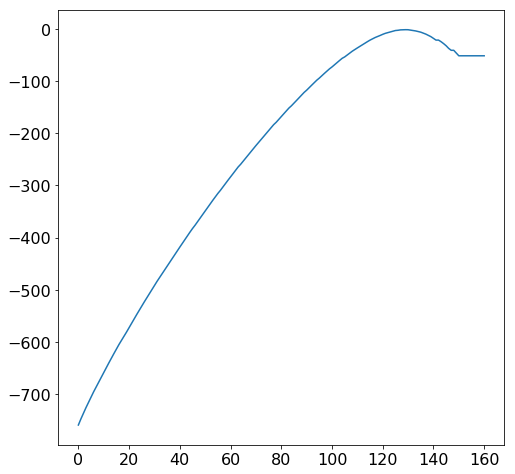

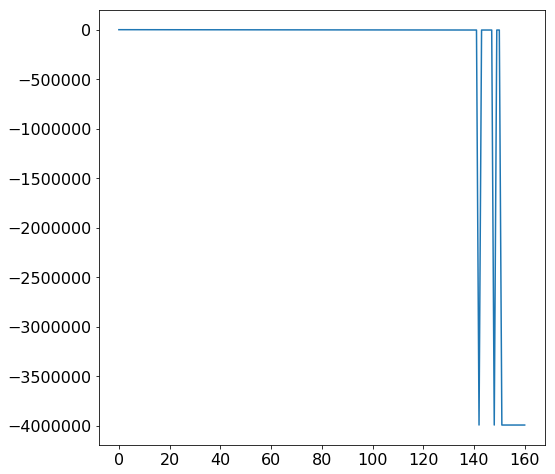

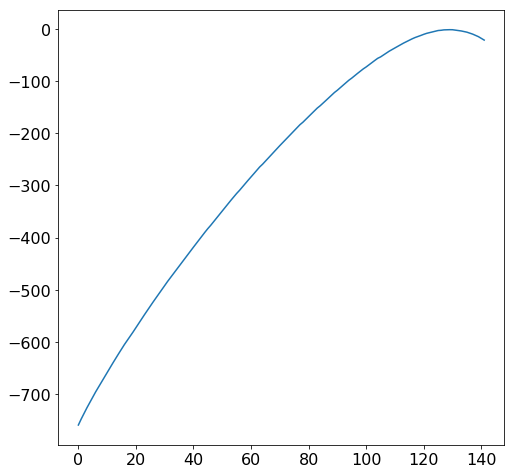

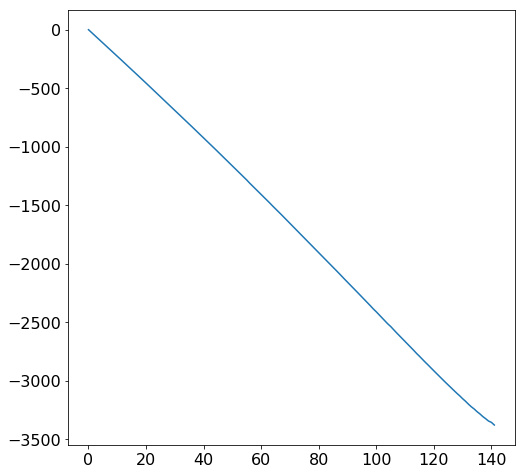

In [5]:
#Confined Data
source = "/home/local/NIST/dsideriu/Workstation_Research/Monte_Carlo/my_FEASST/MFI_Argon/MFI_DIMERArgon_LJLFS/tmp"
N, lnPi, energy, energy2, beta, lnZ = splice_window_data(source,"rst_core")

fig = plt.figure(figsize=(8,8))
plt.plot(N,lnPi)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.plot(N,energy)
plt.show()

#Trim unconverged data
trimN = 141
N = N[0:(trimN+1)]
lnPi = lnPi[0:(trimN+1)]
energy = energy[0:(trimN+1)]
energy2 = energy2[0:(trimN+1)]

fig = plt.figure(figsize=(8,8))
plt.plot(N,lnPi)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.plot(N,energy)
plt.show()

# Instantiate the confined fluid data object
confined = FHMC_Analysis(lnZ,1.,beta)
confined.N = N
confined.lnPi = lnPi
confined.energy = energy
confined.energy2 = energy2

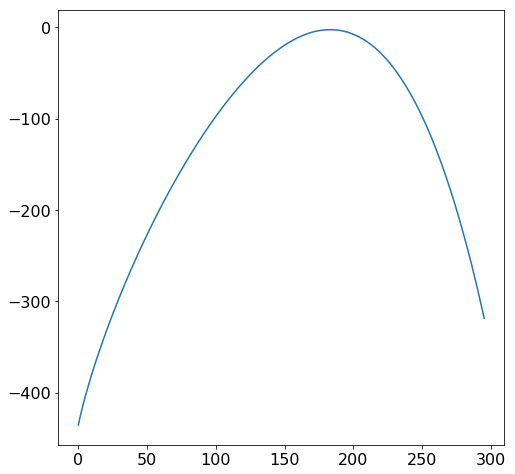

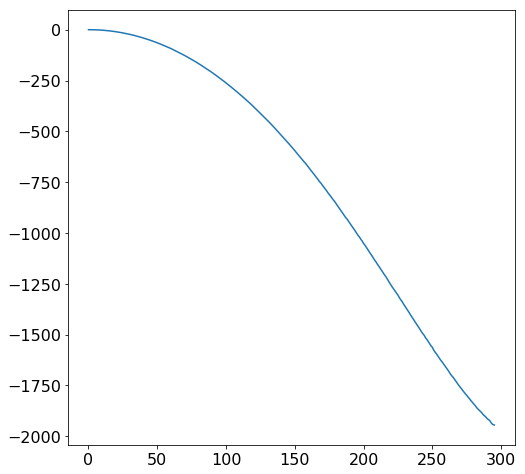

In [6]:
#Bulk Data
source = "/home/local/NIST/dsideriu/Workstation_Research/Monte_Carlo/my_FEASST/MFI_Argon/BULK_DIMER_LJLFS/tmp"
N, lnPi, energy, energy2, beta, lnZ = splice_window_data(source,"rst_core")

fig = plt.figure(figsize=(8,8))
plt.plot(N,lnPi)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.plot(N,energy)
plt.show()

#Trim unconverged data
#trimN = 279
#N = N[0:(trimN+1)]
#lnPi = lnPi[0:(trimN+1)]
#energy = energy[0:(trimN+1)]
#energy2 = energy2[0:(trimN+1)]

#Convert the activity and temperature
#sigma_LJ = 3.405 #Angstroms
#eps_LJ = 119.80 #K
#lnZ = lnZ - 3.*np.log(sigma_LJ)
#beta = beta/eps_LJ/kB/Na * 1.e3
#energy = energy * eps_LJ * kB * Na / 1.e3
V = 30.**3 #Angstroms^3

# Instantiate the confined fluid data object
bulk = FHMC_Analysis(lnZ,V,beta)
bulk.N = N
bulk.lnPi = lnPi
bulk.energy = energy
bulk.energy2 = energy2

In [22]:
for lnZ_rw in np.linspace(-7.,2.4,20):
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    print(lnZ_rw, new.pressure())
print()
for lnZ_rw in np.linspace(-14.,-2.1,20):
    new = confined.reweight(lnZ_rw,CheckTail=True)
    print(lnZ_rw, new.phase_properties()["N"][0])

-7.0 [0.0037080826069163376]
-6.505263157894737 [0.005956691327160746]
-6.010526315789473 [0.009417376822737378]
-5.51578947368421 [0.014480277175403107]
-5.021052631578947 [0.021390758354416554]
-4.526315789473684 [0.030163458487447163]
-4.031578947368421 [0.04064315668749758]
-3.536842105263158 [0.05261064166046843]
-3.0421052631578944 [0.0658586592539021]
-2.5473684210526315 [0.0802417731577122]
-2.052631578947368 [0.09560927675141365]
-1.5578947368421048 [0.11186376003889976]
-1.0631578947368414 [0.12889653408935173]
-0.568421052631578 [0.14663500944067456]
-0.07368421052631557 [0.16504648833108845]
0.4210526315789478 [0.18405442797385052]
0.9157894736842112 [0.2036100498651161]
1.4105263157894736 [0.22369536034465595]
1.905263157894737 [0.2442784378105194]
2.4 [0.26532224348659156]

-14.0 [1.9506138090556493]
-13.373684210526315 [3.479304644376242]
-12.74736842105263 [5.982952670762577]
-12.121052631578948 [10.631142101341588]
-11.494736842105263 [16.321777041785893]
-10.868421052

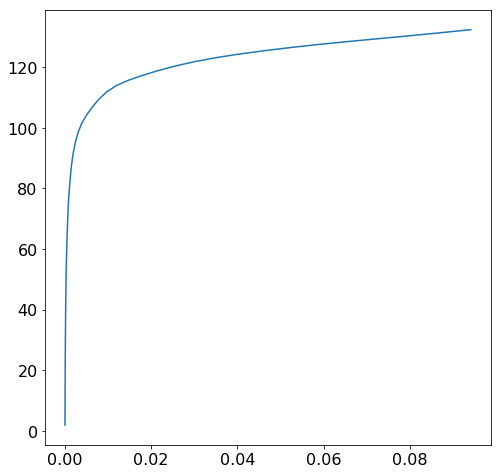

In [24]:
#Adsorption Isotherm
mus = np.linspace(-14.,-2.1,50)

pressure = []
adsorption = []

for lnZ_rw in mus:
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    p = new.pressure()[0]
    new = confined.reweight(lnZ_rw,CheckTail=True)
    #print(lnZ_rw+3.*np.log(sigma_LJ), p, new.phase_properties()["N"][0][0])
    pressure.append(p)
    adsorption.append(new.phase_properties()["N"][0][0])
    
fig = plt.figure(figsize=(8,8))
plt.plot(pressure,adsorption)
plt.show()

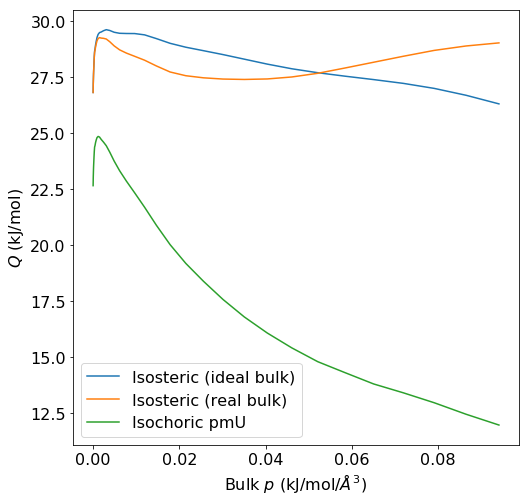

In [25]:
# Isosteric Heat Calculations

mus = np.linspace(-14.,-2.1,50)
Q_trad = []
Q_isochoric = []
Q_proper = []
pressure = []

for lnZ_rw in mus:
    #Bulk Phase
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    props_bulk = new.phase_properties()
    pressure.append( new.pressure()[0]  )
    Nav_b = props_bulk["N"][0][0]
    Uav_b = props_bulk["U"][0]
    fUN_b = (props_bulk["UN"][0] - props_bulk["U"][0]*props_bulk["N"][0][0])
    fNN_b = (props_bulk["N"][1][0]-props_bulk["N"][0][0]**2)
    
    #Confined Phase
    new = confined.reweight(lnZ_rw,CheckTail=True)
    props_confined = new.phase_properties()
    Nav_c = props_confined["N"][0][0]
    fUN_c = (props_confined["UN"][0] - props_confined["U"][0]*props_confined["N"][0][0])
    fNN_c = (props_confined["N"][1][0]-props_confined["N"][0][0]**2)
        
    Q_trad.append( 1/bulk.beta - fUN_c/fNN_c )
    Q_isochoric.append( fUN_b/fNN_b - fUN_c/fNN_c )
    Q_proper.append( (Uav_b + pressure[-1]*bulk.V)/Nav_b  - fUN_c/fNN_c  )
    
    #print(lnZ_rw,pressure[-1])
    #print(Q_trad[-1])
    #print(Q_proper[-1])
    #print(Q_isochoric[-1])

    
Q_trad = np.array(Q_trad)
Q_isochoric = np.array(Q_isochoric)
Q_proper = np.array(Q_proper)
    
fig = plt.figure(figsize=(8,8))
plt.plot(pressure, Q_trad, label="Isosteric (ideal bulk)")
plt.plot(pressure, Q_proper, label="Isosteric (real bulk)")
plt.plot(pressure, Q_isochoric, label="Isochoric pmU")
#plt.gca().set_ylim(0,20.0)
plt.legend()
plt.xlabel(r'Bulk $p$ (kJ/mol/$\AA^3$)')
plt.ylabel(r'$Q$ (kJ/mol)')
plt.show()

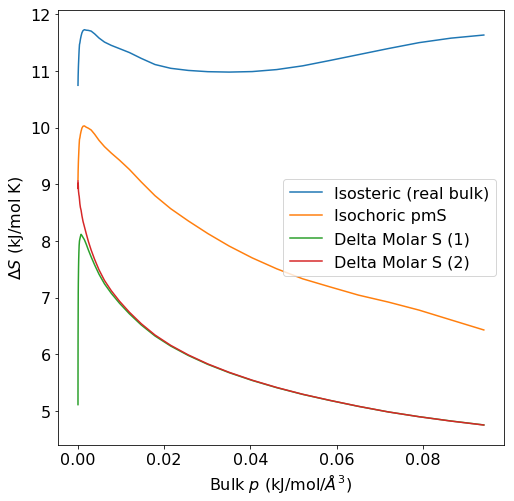

In [26]:
# Change in molar entropy [equivalent to the change in partial molar entropy]

mus = np.linspace(-14.,-2.1,50)
delta_molar_S = []
delta_isochoric_S = []
delta_isosteric_S = []
delta_isosteric_S_trad = []
delta_S = []
pressure = []

#delta_molar_S: GC average based on canonical entropies
#delta_S: GC entropy based on "direct" calculation

for lnZ_rw in mus:
    #Bulk Phase
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_b = Sx[0]/props["N"][0][0]
    isochoric_pmS_b = bulk.beta*(props["UN"][0]-props["U"][0]*props["N"][0][0])/(props["N"][1][0] -props["N"][0][0]**2) - new.lnZ0
    pressure.append( new.pressure()[0]  )
    pmH = (props["U"][0] + pressure[-1]*bulk.V)/props["N"][0][0]
    Sbulk = ( props["U"][0] - lnZ_rw*props["N"][0][0]/new.beta -new.grand_potential()[0] )/props["N"][0][0]*new.beta
        
    #Confined Phase
    new = confined.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_c = Sx[0]/props["N"][0][0]
    isochoric_pmS_c = confined.beta*(props["UN"][0]-props["U"][0]*props["N"][0][0])/(props["N"][1][0] -props["N"][0][0]**2) - new.lnZ0
    fUN_c = props["UN"][0]-props["U"][0]*props["N"][0][0]
    fNN_c = props["N"][1][0]-props["N"][0][0]**2
    Sconfined = ( props["U"][0] - lnZ_rw*props["N"][0][0]/new.beta -new.grand_potential()[0] )/props["N"][0][0]*new.beta
    
    #Bulk - Confined
    delta_molar_S.append(molar_S_b - molar_S_c)
    delta_S.append( Sbulk - Sconfined )
    delta_isochoric_S.append(isochoric_pmS_b-isochoric_pmS_c)
    delta_isosteric_S.append( (pmH -fUN_c/fNN_c)*new.beta )
    delta_isosteric_S_trad.append( 1 - fUN_c/fNN_c*new.beta )
    
    #print(Sbulk, Sconfined)
    #print(lnZ_rw, molar_S_b-molar_S_c)

delta_molar_S = np.array(delta_molar_S)
delta_S = np.array(delta_S)
delta_isochoric_S = np.array(delta_isochoric_S)
delta_isosteric_S = np.array(delta_isosteric_S)
delta_isosteric_S_trad = np.array(delta_isosteric_S_trad)
    
fig = plt.figure(figsize=(8,8))
#plt.plot(pressure, delta_isosteric_S_trad, label = 'Isosteric (ideal bulk)')
plt.plot(pressure, delta_isosteric_S, label = 'Isosteric (real bulk)')
plt.plot(pressure, delta_isochoric_S,  label = 'Isochoric pmS')
plt.plot(pressure, delta_molar_S, label = 'Delta Molar S (1)')
plt.plot(pressure, delta_S, label = 'Delta Molar S (2)')
plt.legend()
plt.xlabel(r'Bulk $p$ (kJ/mol/$\AA^3$)')
plt.ylabel(r'$\Delta S$ (kJ/mol K)')
plt.show()

In [27]:
#Check bulk-phase nonideality
for lnZ_rw in mus:
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    props =new.phase_properties() 
    pmH = 1.5/new.beta + (props["U"][0] + new.pressure()[0]*new.V)/props["N"][0][0]

    #Comparison of partial molar enthalpy
    #print(lnZ_rw, pmH, 5./2./new.beta)
    
    #Comparison of pressure w/ NkT/V
    #print(lnZ_rw, new.pressure()[0], props[0][0][0]/new.V/new.beta) 
    
    #Comparison of pressure w/ mu-mapped ideal gas pressure
    print(lnZ_rw, new.pressure()[0], np.exp(lnZ_rw)/new.beta)

-14.0 3.4512363806193818e-06 3.4568570283625897e-06
-13.757142857142858 4.399938463083653e-06 4.407100304198215e-06
-13.514285714285714 5.609427334868645e-06 5.618552613517808e-06
-13.271428571428572 7.15138961170519e-06 7.163016789247082e-06
-13.028571428571428 9.117216457522946e-06 9.132033292629599e-06
-12.785714285714286 1.1623418371067233e-05 1.16423058204867e-05
-12.542857142857143 1.481852640182265e-05 1.4842618338583452e-05
-12.3 1.8891886342233867e-05 1.8922653513979222e-05
-12.057142857142857 2.4084862383893072e-05 2.412423521524599e-05
-11.814285714285715 3.0705105593804444e-05 3.075566142404782e-05
-11.571428571428571 3.9144717795271026e-05 3.920997707039725e-05
-11.32857142857143 4.990336285657545e-05 4.9988269823355705e-05
-11.085714285714285 6.361765884231835e-05 6.372936957974363e-05
-10.842857142857143 8.109854659328566e-05 8.124771194089113e-05
-10.6 0.00010337880409519043 0.00010358160984740421
-10.357142857142858 0.00013177350537305242 0.00013205479443390917
-10.114

In [28]:
# Change in molar entropy [equivalent to the change in partial molar entropy]

mus = np.linspace(-14.,-2.1,50)
#delta_molar_S = []
#delta_isochoric_S = []
#delta_isosteric_S = []
#delta_isosteric_S_trad = []
#delta_S = []
#pressure = []

#delta_molar_S: GC average based on canonical entropies
#delta_S: GC entropy based on "direct" calculation

for lnZ_rw in mus:
    #Bulk Phase
    new = bulk.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_b = Sx[0]/props["N"][0][0]
    isochoric_pmS_b = bulk.beta*(props["UN"][0]-props["U"][0]*props["N"][0][0])/(props["N"][1][0] -props["N"][0][0]**2) - new.lnZ0
    pressure.append( new.pressure()[0]  )
    pmH = (props["U"][0] + pressure[-1]*bulk.V)/props["N"][0][0]
    Sbulk = ( props["U"][0] - lnZ_rw*props["N"][0][0]/new.beta -new.grand_potential()[0] )/props["N"][0][0]*new.beta
        
    #Confined Phase
    new = confined.reweight(lnZ_rw,CheckTail=True)
    Sx = new.grandcanonical_entropy_ex_phases()
    props = new.phase_properties()
    molar_S_c = Sx[0]/props["N"][0][0]
    isochoric_pmS_c = confined.beta*(props["UN"][0]-props["U"][0]*props["N"][0][0])/(props["N"][1][0] -props["N"][0][0]**2) - new.lnZ0
    fUN_c = props["UN"][0]-props["U"][0]*props["N"][0][0]
    fNN_c = props["N"][1][0]-props["N"][0][0]**2
    Sconfined = ( props["U"][0] - lnZ_rw*props["N"][0][0]/new.beta -new.grand_potential()[0] )/props["N"][0][0]*new.beta
    
    SNx_confined = new.SNx_ensemble()
    fSN_c = (SNx_confined - Sx[0]*props["N"][0][0] )
    
    #Bulk - Confined
    #delta_molar_S.append(molar_S_b - molar_S_c)
    #delta_S.append( Sbulk - Sconfined )
    #delta_isochoric_S.append(isochoric_pmS_b-isochoric_pmS_c)
    #delta_isosteric_S.append( (pmH -fUN_c/fNN_c)*new.beta )
    #delta_isosteric_S_trad.append( 1 - fUN_c/fNN_c*new.beta )
    print(lnZ_rw, (pmH -fUN_c/fNN_c)*new.beta ,
          Sbulk - new.beta*(fUN_c/fNN_c) + lnZ_rw,
          molar_S_b - new.beta*(fUN_c/fNN_c) + lnZ_rw)
    #print(lnZ_rw, fSN_c/fNN_c,  new.beta*(fUN_c/fNN_c) - lnZ_rw)

-14.0 10.74688634297936 10.080318133190858 5.274540034359497
-13.757142857142858 10.751438668637913 10.08489712407185 5.5198569059412375
-13.514285714285714 10.756942354860525 10.090434566461747 5.765554661030757
-13.271428571428572 10.763844350773143 10.097379220275059 6.011926390655866
-13.028571428571428 10.772678859623257 10.106267521967311 6.259311983335756
-12.785714285714286 10.782849813134716 10.116506138980975 6.506870612343315
-12.542857142857143 10.79337370306252 10.127114891325784 6.753311526898104
-12.3 10.80791235424689 10.14175962882155 7.0019125799773185
-12.057142857142857 10.833361079749649 10.167340517565293 7.259091974417224
-11.814285714285715 10.869732943685888 10.20387649322702 7.524274357848162
-11.571428571428571 10.906108824530769 10.24045564168062 7.78582198688393
-11.32857142857143 10.935667491597043 10.27026584512069 8.036047183558036
-11.085714285714285 10.971029167175825 10.305939367179185 8.28654298775924
-10.842857142857143 11.021647111009441 10.3569461